# 📘 Machine Learning 2025/2026  

## Laboratorio 4.2 — Modelli Probabilistici e Regressione Bayesiana  
## Docenti: Danilo Croce, Giorgio Gambosi  

---

### 🎯 Introduzione

Nel laboratorio precedente abbiamo affrontato la regressione lineare come **problema di ottimizzazione deterministica**, stimando i parametri del modello minimizzando l’errore quadratico medio e introducendo la **regolarizzazione** (Ridge, Lasso) per controllare l’overfitting.

In questa seconda parte adottiamo un approccio **probabilistico**:  
invece di trovare un solo insieme di pesi $\mathbf{w}$, descriveremo la **distribuzione di probabilità** sui possibili valori dei parametri e delle predizioni.  
Questo ci permetterà di modellare anche l’**incertezza** del modello.

---

### 🧩 Obiettivi del laboratorio

- Definire un **modello probabilistico** per la regressione:
  $$
  p(t|\mathbf{x}, \mathbf{w}, \beta) = \mathscr{N}(t|h(\mathbf{x}; \mathbf{w}), \beta^{-1})
  $$
- Derivare le stime di **massima verosimiglianza (ML)** per $\mathbf{w}$ e $\beta$, mostrando il legame con i **minimi quadrati**.  
- Introdurre la **regressione bayesiana**, con prior gaussiano:
  $$
  p(\mathbf{w}|\alpha) = \mathscr{N}(\mathbf{w}; 0, \alpha^{-1}I)
  $$
  e posterior:
  $$
  p(\mathbf{w}|\mathbf{X}, \mathbf{t}) = \mathscr{N}(\mathbf{w}; \mathbf{m}_p, \Sigma_p)
  $$
  dove  
  $$\Sigma_p = (\alpha I + \beta X^TX)^{-1}$$
  $$\mathbf{m}_p = \beta \Sigma_p X^T t$$.
- Mostrare graficamente come il **posterior si restringe** man mano che osserviamo nuovi dati (apprendimento sequenziale).


---

📘 **In sintesi:**  
- la regressione lineare è reinterpretata in chiave probabilistica,  
- l’approccio bayesiano consente di stimare sia il valore previsto sia la **confidenza** della stima,  
- e di aggiornare progressivamente le conoscenze man mano che arrivano nuovi dati.

---

## 1️⃣ Setup e generazione del dataset sintetico

Per studiare la regressione probabilistica, generiamo un piccolo dataset artificiale.  
Il nostro obiettivo è simulare una relazione (non perfettamente lineare) tra una variabile di input $x$ e un target $t$, affetto da **rumore gaussiano**.

In altre parole, assumeremo che:

$$
t = f(x) + \epsilon, \quad \epsilon \sim \mathscr{N}(0, \sigma^2)
$$

dove $f(x)$ è la “vera” funzione sottostante e $\epsilon$ rappresenta il rumore osservazionale.

Questo ci permetterà di verificare come un modello di regressione lineare — e successivamente bayesiano — possa stimare i parametri anche in presenza di incertezza.

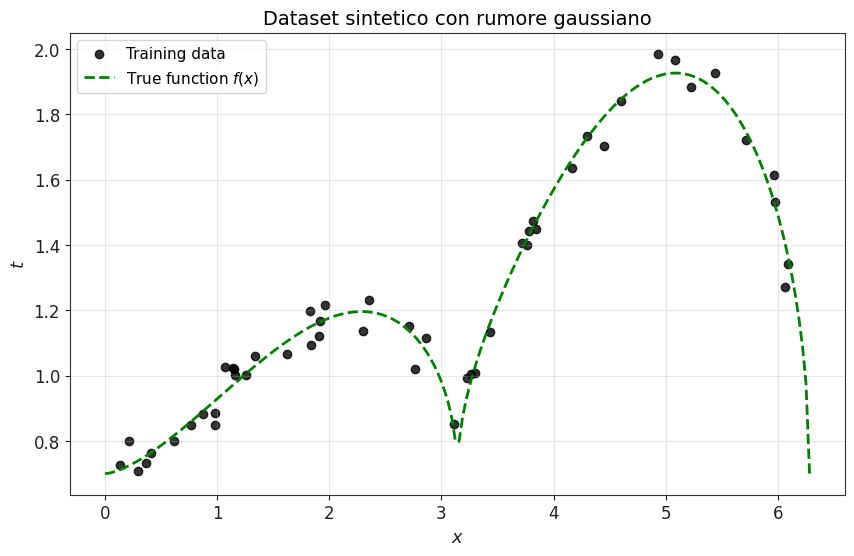

In [ ]:
# ============================================================
# 1️⃣ Generazione del dataset sintetico
# ============================================================

# ============================================================
# 📦 IMPORT PRINCIPALI
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# ============================================================
# ✨ CONFIGURAZIONE PLOTTING
# ============================================================

plt.style.use('default')

plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'lines.linewidth': 2.2,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.edgecolor': '#333333',
    'axes.labelcolor': '#222222',
    'xtick.color': '#222222',
    'ytick.color': '#222222',
})

# (Facoltativo, per risultati riproducibili)
np.random.seed(42)


def f(x):
    """Funzione vera (non lineare) che genera i dati."""
    return 0.7 + 0.25 * x * np.sqrt(np.abs(np.sin(x)))

n = 50
domain = (0, 2 * np.pi)
X = np.random.uniform(domain[0], domain[1], n)

# Rumore gaussiano
noise_sd = 0.05
beta = 1.0 / (noise_sd**2)   # precisione = 1 / varianza del rumore

# Target
t = np.array([f(v) + np.random.normal(0, noise_sd) for v in X]).reshape(-1, 1)

# Plot
xx = np.linspace(*domain, 200)
plt.scatter(X, t, color="black", alpha=0.8, label="Training data")
plt.plot(xx, f(xx), "g--", linewidth=2, label="True function $f(x)$")
plt.title("Dataset sintetico con rumore gaussiano")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.legend()
plt.show()

Osserviamo che i punti neri rappresentano i dati osservati $(x_i, t_i)$, mentre la linea verde tratteggiata mostra la **vera funzione** $f(x)$ utilizzata per generarli.

Il rumore gaussiano aggiunto ai dati riflette l’assunzione del modello probabilistico:

$$
p(t|x; \mathbf{w}, \beta) = \mathscr{N}(t \mid h(x; \mathbf{w}), \beta^{-1})
$$

dove $\beta^{-1} = \sigma^2$ rappresenta la varianza del rumore, e $h(x; \mathbf{w})$ è la funzione predittiva del modello (nel nostro caso, lineare o polinomiale).  

Nei prossimi passi definiremo formalmente tale modello e introdurremo il **prior** sui parametri.

> 💡 **Nota sulla notazione:**  
> In statistica bayesiana si usa spesso $\beta$ (chiamata *precisione*) al posto della varianza $\sigma^2$.  
> Le due quantità sono legate da $\displaystyle \beta = \frac{1}{\sigma^2}$.  
> Questa scelta è solo una convenzione utile:  
> - $\sigma^2$ misura **quanto rumore** c’è nei dati (dispersione).  
> - $\beta$ misura **quanto è preciso** il modello (l’inverso della dispersione).  
> Una $\beta$ grande significa rumore basso e quindi predizioni più “sicure”.  
> La notazione in termini di $\beta$ rende le formule della *log-likelihood* e del *posterior* più compatte e semplici da derivare.

## 2️⃣ Modello probabilistico e prior sui parametri (spiegato semplice)

Finora, nella regressione lineare classica, cercavamo **i pesi** $\mathbf{w}$ che meglio approssimano i dati.  
In quel caso, i pesi erano **numeri fissi** da stimare risolvendo un problema di ottimizzazione.

Nel mondo **bayesiano**, invece, cambiamo prospettiva:
> I pesi $\mathbf{w}$ non sono valori deterministici, ma **variabili casuali**  
> che possono assumere diversi valori con probabilità diverse.

---

### 🎯 Il modello probabilistico

Assumiamo che ogni osservazione $t$ derivi da:
- una funzione deterministica $h(\mathbf{x}; \mathbf{w})$ (il nostro modello),  
- più un **rumore gaussiano** (errori casuali, misurazioni imperfette...).

$$
p(t | \mathbf{x}, \mathbf{w}, \beta) = \mathscr{N}(t \mid h(\mathbf{x}; \mathbf{w}), \beta^{-1})
$$

👉 Significa che ogni valore osservato $t$ è distribuito secondo una **Gaussiana** centrata sulla previsione del modello, con varianza $\beta^{-1}$ (cioè $\sigma^2$), che rappresenta l’intensità del rumore.

---

### 💭 Cos’è il “prior”

Prima ancora di osservare i dati, possiamo avere un’idea su **quali valori dei pesi $\mathbf{w}$ siano plausibili**. Questa credenza iniziale si chiama **prior** (*distribuzione a priori*).

Ad esempio, se pensiamo che i pesi del modello non debbano essere enormi,  possiamo esprimere questa idea dicendo che sono distribuiti intorno a zero con una certa incertezza:

$$
p(\mathbf{w} | \alpha) = \mathscr{N}(\mathbf{w}; \mathbf{0}, \alpha^{-1}\mathbf{I})
$$

- $\mathbf{w}$ è il vettore dei pesi del modello (es. $[w_0, w_1, \dots, w_M]^T$)  
- $\mathbf{0}$ è un vettore di zeri: la **media del prior**, cioè il punto in cui crediamo che i pesi tendano a stare  
- $\alpha^{-1}\mathbf{I}$ è la **covarianza**, che stabilisce quanto i pesi possono discostarsi da zero

👉 In pratica:  
> *“Credo che i pesi siano probabilmente piccoli (vicini a zero),  ma non escludo che possano assumere valori diversi se i dati lo giustificano.”*

---

### ⚙️ Il ruolo di $\alpha$

Il parametro $\alpha$ è detto **precisione del prior** (inverso della varianza).  
Controlla quanto fortemente i pesi vengono spinti verso zero:

| Caso | Varianza $1/\alpha$ | Effetto |
|------|----------------------|---------|
| $\alpha$ grande | piccola | pesi fortemente penalizzati → modello rigido, poco flessibile |
| $\alpha$ piccolo | grande | pesi liberi di variare → modello flessibile ma a rischio overfitting |

Quindi, $\alpha$ gioca lo stesso ruolo della **regolarizzazione nella Ridge Regression**: evita che i pesi diventino troppo grandi e che il modello impari il rumore (vedi in fondo!!!).

---

### 🔁 Dati + Prior = Posterior

Quando arrivano i dati, aggiorniamo la nostra credenza iniziale combinando **prior** e **verosimiglianza** (likelihood):

$$
p(\mathbf{w}|\mathbf{X},\mathbf{t}) \propto p(\mathbf{t}|\mathbf{X},\mathbf{w}) \, p(\mathbf{w})
$$

- **Likelihood** $p(\mathbf{t}|\mathbf{X},\mathbf{w},\beta)$ → quanto bene i dati sono spiegati dai pesi  
- **Prior** $p(\mathbf{w}|\alpha)$ → quanto crediamo che certi pesi siano plausibili  
- **Posterior** $p(\mathbf{w}|\mathbf{X},\mathbf{t})$ → la nuova conoscenza dopo aver visto i dati

---

### 💡 In sintesi

| Concetto | Significato | Intuizione |
|-----------|--------------|------------|
| **Prior** | credenza iniziale sui pesi | “prima dei dati, penso che i pesi siano piccoli” |
| **Likelihood** | compatibilità con i dati | “quanto bene i pesi spiegano ciò che ho osservato” |
| **Posterior** | conoscenza aggiornata | “ora so quali pesi sono più plausibili” |

---

Nel codice qui sotto:  
- definiamo un modello lineare semplice $h(x) = w_0 + w_1x$,  
- campioniamo diverse coppie di pesi $(w_0, w_1)$ dal prior,  
- e mostriamo le **rette corrispondenti**: sono le possibili funzioni che il modello ritiene plausibili *prima di aver visto i dati*.


🎲 Campioni dal prior (w₀, w₁):

 1) w₀ =  0.137,  w₁ =  1.370
 2) w₀ = -0.993,  w₁ = -0.463
 3) w₀ = -0.555,  w₁ = -2.070
 4) w₀ =  0.419,  w₁ =  0.369
 5) w₀ =  0.007,  w₁ = -0.332
 6) w₀ = -2.002,  w₁ = -0.595
 7) w₀ = -0.485,  w₁ = -1.135
 8) w₀ = -0.228,  w₁ =  0.571
 9) w₀ =  2.667,  w₁ =  0.247
10) w₀ =  0.364,  w₁ = -0.105


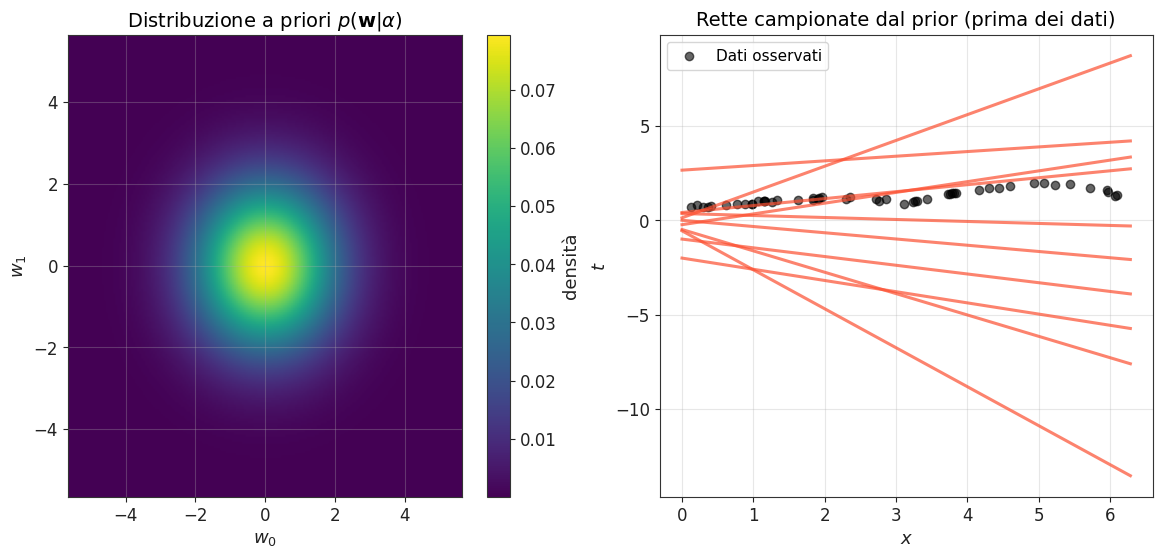

In [ ]:
# ============================================================
# 2️⃣ MODELLO LINEARE E PRIOR GAUSSIANO SUI PARAMETRI
# ============================================================

def design_matrix(x, n_cols):
    """Crea la matrice Φ = [1, x, x², …] per il modello lineare."""
    x = np.asarray(x).reshape(-1)
    return np.vstack([x**i for i in range(n_cols)]).T


# ------------------------------------------------------------
# MODELLO LINEARE: h(x) = w₀ + w₁x
# ------------------------------------------------------------
n_coeff = 2                      # due parametri: bias e pendenza
Phi = design_matrix(X, n_coeff)  # matrice Φ per i punti di training


# ------------------------------------------------------------
# PRIOR GAUSSIANO SUI PESI: p(w|α) = N(0, α⁻¹I)
# ------------------------------------------------------------
alpha = 0.5                      # precisione (1 / varianza)
mu_prior = np.zeros(n_coeff)     # media = [0, 0] → pesi attesi vicini a 0
Sigma_prior = np.eye(n_coeff) / alpha  # covarianza isotropica (pesi indipendenti)

# Campioniamo n possibili coppie (w₀, w₁)
n_sample = 10
samples_prior = np.random.multivariate_normal(mu_prior, Sigma_prior, n_sample)

print("🎲 Campioni dal prior (w₀, w₁):\n")
for i, w in enumerate(samples_prior[:n_sample]):
    print(f"{i+1:>2}) w₀ = {w[0]: .3f},  w₁ = {w[1]: .3f}")

# ------------------------------------------------------------
# VISUALIZZAZIONE
# ------------------------------------------------------------

# Griglia regolare di punti per disegnare le rette continue
xx = np.linspace(*domain, 200)
Phi_xx = design_matrix(xx, n_coeff)

# --- Distribuzione del prior nel piano (w₀, w₁)
sd0, sd1 = np.sqrt(Sigma_prior[0, 0]), np.sqrt(Sigma_prior[1, 1])
w0_grid = np.linspace(-4 * sd0, 4 * sd0, 200)
w1_grid = np.linspace(-4 * sd1, 4 * sd1, 200)
prior = st.multivariate_normal(mean=mu_prior, cov=Sigma_prior)
Z_prior = np.array([[prior.pdf([w0, w1]) for w0 in w0_grid] for w1 in w1_grid])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(Z_prior,
           extent=(w0_grid.min(), w0_grid.max(), w1_grid.min(), w1_grid.max()),
           origin='lower', aspect='auto')
plt.title("Distribuzione a priori $p(\\mathbf{w}|\\alpha)$")
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.colorbar(label="densità")

# --- A destra: rette generate dai pesi campionati
plt.subplot(1, 2, 2)
plt.scatter(X, t, color="black", alpha=0.6, label="Dati osservati")
for w in samples_prior:
    plt.plot(xx, Phi_xx @ w, color="#fc4f30", alpha=0.7)
plt.title("Rette campionate dal prior (prima dei dati)")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.legend()
plt.show()

### 🔍 Interpretazione

- **A sinistra:** la **distribuzione a priori** dei parametri $(w_0, w_1)$,  
che rappresenta la nostra *conoscenza iniziale* prima di osservare alcun dato.   È una Gaussiana centrata in $(0, 0)$: significa che riteniamo più probabili  i valori dei pesi vicini a zero, ma non escludiamo valori più grandi.

- **A destra:** alcune **rette di regressione campionate** dal prior.  
  Poiché la varianza del prior è ampia (cioè $\alpha$ è piccolo),  le rette risultano molto diverse tra loro — segno di **alta incertezza**
  su quale modello descriva davvero i dati.

🧠 Nei prossimi passi vedremo come l’osservazione dei dati *aggiorna* questa conoscenza iniziale, portando a una **distribuzione a posteriori** più concentrata attorno ai valori plausibili di $\mathbf{w}$.

----

## 3️⃣ Aggiornamento del modello: distribuzione a posteriori dei parametri

Finora abbiamo definito un **prior** sui pesi $\mathbf{w}$, che esprime la nostra conoscenza *prima* di osservare i dati.

Ora, dopo aver visto un insieme di esempi $(\mathbf{x}_i, t_i)$, possiamo aggiornare tale conoscenza grazie al **teorema di Bayes**:

$$
p(\mathbf{w} | \mathbf{X}, \mathbf{t}; \alpha, \beta)
\propto p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \beta) \; p(\mathbf{w} | \alpha)
$$

dove:
- $p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \beta)$ → è la **verosimiglianza** (*likelihood*),   cioè quanto bene i pesi $\mathbf{w}$ spiegano i dati osservati;
- $p(\mathbf{w} | \alpha)$ → è il **prior**, cioè le nostre credenze iniziali sui pesi.

---

### 📈 Forma del posterior

Poiché **sia la likelihood che il prior sono gaussiane**, il risultato della loro combinazione (il **posterior**) è anch’esso una **Gaussiana**:

$$
p(\mathbf{w} | \mathbf{X}, \mathbf{t}; \alpha, \beta)
= \mathscr{N}(\mathbf{w}; \mathbf{m}_p, \Sigma_p)
$$

dove:
- $\mathbf{m}_p$ è la **media a posteriori** (i pesi più probabili dopo aver visto i dati),
- $\Sigma_p$ è la **covarianza a posteriori** (incertezza residua sui pesi).

Le formule sono:

$$
\Sigma_p = (\Sigma_0^{-1} + \beta \mathbf{X}^T \mathbf{X})^{-1}
\quad\text{e}\quad
\mathbf{m}_p = \Sigma_p (\Sigma_0^{-1} \mathbf{m}_0 + \beta \mathbf{X}^T \mathbf{t})
$$

Nel nostro caso:
- $\mathbf{m}_0 = 0$ (il prior è centrato in zero),  
- $\Sigma_0 = \alpha^{-1} \mathbf{I}$ (prior isotropico).

---

👉 In pratica, il **posterior** rappresenta una versione aggiornata del prior:  dopo aver osservato i dati, la distribuzione diventa **più concentrata** attorno ai valori di $\mathbf{w}$ che spiegano meglio le osservazioni.

## 📘 APPROFONDIMENTO: Da dove vengono le formule del *posterior*

Finora abbiamo detto che nel mondo bayesiano non stimiamo un singolo vettore di pesi $\mathbf{w}$, ma una **distribuzione** su di essi: il *posterior*.  

Vediamo ora come si ottiene matematicamente, passo per passo.

---

### 🎯 1️⃣ Likelihood — il modello dei dati


Ricordiamo la forma **base** della distribuzione normale (in una dimensione):

$$
\mathscr{N}(x \mid \mu, \sigma^2)
= \frac{1}{\sqrt{2\pi\sigma^2}}
\,\exp\!\left[-\frac{(x-\mu)^2}{2\sigma^2}\right].
$$

Nella forma **multivariata** (per un vettore $\mathbf{x}$ di dimensione $n$):

$$
\mathscr{N}(\mathbf{x} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma})
= \frac{1}{(2\pi)^{n/2}|\boldsymbol{\Sigma}|^{1/2}}
\,\exp\!\left[-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^\top
\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right].
$$


Assumiamo che i target $\mathbf{t}$ siano generati da un modello lineare più rumore:

$$
\mathbf{t} = \mathbf{Xw} + \varepsilon,
\qquad
\varepsilon \sim \mathscr{N}(\mathbf{0}, \beta^{-1}\mathbf{I})
$$

Qui:
- $\mathbf{X}$ → matrice delle feature ($n\times m$)
- $\mathbf{w}$ → vettore dei coefficienti (bias incluso)
- $\mathbf{t}$ → vettore dei target osservati
- $\beta$ → **precisione** del rumore, cioè $\beta = 1 / \sigma^2$

La **likelihood** (probabilità dei dati dato $\mathbf{w}$) è:

$$
p(\mathbf{t}|\mathbf{X},\mathbf{w},\beta)
= \frac{1}{(2\pi)^{\frac{n}{2}}|\beta^{-1}\mathbf{I}|^{\frac{1}{2}}}
\exp\!\left[-\frac{1}{2}(\mathbf{t}-\mathbf{Xw})^\top(\beta^{-1}\mathbf{I})^{-1}(\mathbf{t}-\mathbf{Xw})\right]
= \left(\frac{\beta}{2\pi}\right)^{\frac{n}{2}}
e^{-\frac{\beta}{2}\|\mathbf{t}-\mathbf{Xw}\|^2}.
$$

👉 Il termine $\|\mathbf{t}-\mathbf{Xw}\|^2$ è la **somma dei quadrati degli errori di predizione**.


#### 🧾 Log-likelihood

È spesso utile passare ai logaritmi (trasforma prodotti in somme):

$$
\log p(\mathbf{t}|\mathbf{X},\mathbf{w},\beta)
= \frac{n}{2}\log\beta - \frac{n}{2}\log(2\pi)
- \frac{\beta}{2}\|\mathbf{t}-\mathbf{Xw}\|^2.
$$

> 🔸 Usiamo il log perché massimizzare $p$ o $\log p$ è equivalente e il log elimina prodotti e costanti inutili ai fini dell’ottimizzazione.

---

### 🧩 2️⃣ Prior sui pesi

Prima di osservare i dati, esprimiamo la nostra **credenza iniziale** sui pesi $\mathbf{w}$ tramite una distribuzione gaussiana:

$$
p(\mathbf{w}|\alpha)
= \mathscr{N}(\mathbf{w}; \mathbf{m}_0, \Sigma_0)
= \frac{1}{(2\pi)^{\frac{m}{2}}|\Sigma_0|^{\frac{1}{2}}}
\exp\!\left[-\frac{1}{2}(\mathbf{w}-\mathbf{m}_0)^\top\Sigma_0^{-1}(\mathbf{w}-\mathbf{m}_0)\right].
$$

> 🧮 Il termine $(2\pi)^{m/2}$ e il determinante $|\Sigma_0|^{1/2}$  
> sono la **costante di normalizzazione** della gaussiana multivariata: garantiscono che l’integrale della distribuzione valga 1.

- $\mathbf{m}_0$ → media del prior (spesso $\mathbf{0}$)
- $\Sigma_0$ → covarianza (quanto siamo incerti sui pesi)
- $\alpha$ → precisione del prior se $\Sigma_0 = \alpha^{-1}\mathbf{I}$

> 🔹 Se $\Sigma_0 = \alpha^{-1}\mathbf{I}$, il prior è **isotropo**: tutte le direzioni hanno la stessa varianza $1/\alpha$, cioè non privilegiamo nessun peso in particolare.


#### 🧾 Log-prior

$$
\log p(\mathbf{w}|\alpha)
= -\frac{m}{2}\log(2\pi) - \frac{1}{2}\log|\Sigma_0|
- \frac{1}{2}(\mathbf{w}-\mathbf{m}_0)^\top\Sigma_0^{-1}(\mathbf{w}-\mathbf{m}_0).
$$

---

### ⚙️ 3️⃣ Applicazione del teorema di Bayes

Combinando **likelihood** e **prior** otteniamo il **posterior**:

$$
p(\mathbf{w}|\mathbf{X},\mathbf{t})
= \frac{p(\mathbf{t}|\mathbf{X},\mathbf{w},\beta)\;p(\mathbf{w}|\alpha)}
{p(\mathbf{t}|\mathbf{X},\alpha,\beta)}
\;\propto\;
p(\mathbf{t}|\mathbf{X},\mathbf{w},\beta)\;p(\mathbf{w}|\alpha).
$$

Sostituendo le due Gaussiane:

$$
p(\mathbf{w}|\mathbf{X},\mathbf{t})
\propto
\exp\!\left[
-\frac{\beta}{2}\|\mathbf{t}-\mathbf{Xw}\|^2
-\frac{1}{2}(\mathbf{w}-\mathbf{m}_0)^\top\Sigma_0^{-1}(\mathbf{w}-\mathbf{m}_0)
\right].
$$

👉 In logaritmi:

$$
\log p(\mathbf{w}|\mathbf{X},\mathbf{t})
= -\frac{\beta}{2}\|\mathbf{t}-\mathbf{Xw}\|^2
-\frac{1}{2}(\mathbf{w}-\mathbf{m}_0)^\top\Sigma_0^{-1}(\mathbf{w}-\mathbf{m}_0)
+ \text{cost.}
$$

---

### 🧮 4️⃣ Espansione dei termini in $\mathbf{w}$

Espandiamo i quadrati per evidenziare i termini in $\mathbf{w}$.


\begin{aligned}
\|\mathbf{t}-\mathbf{Xw}\|^2
&= \mathbf{t}^\top\mathbf{t}
- 2\mathbf{w}^\top\mathbf{X}^\top\mathbf{t}
+ \mathbf{w}^\top\mathbf{X}^\top\mathbf{Xw}, \\[4pt]
(\mathbf{w}-\mathbf{m}_0)^\top\Sigma_0^{-1}(\mathbf{w}-\mathbf{m}_0)
&= \mathbf{w}^\top\Sigma_0^{-1}\mathbf{w}
- 2\mathbf{w}^\top\Sigma_0^{-1}\mathbf{m}_0
+ \mathbf{m}_0^\top\Sigma_0^{-1}\mathbf{m}_0.
\end{aligned}


Sostituendo:

$$
\log p(\mathbf{w}|\mathbf{X},\mathbf{t})
= -\frac{1}{2}\mathbf{w}^\top(\Sigma_0^{-1}+\beta\mathbf{X}^\top\mathbf{X})\mathbf{w}
+\mathbf{w}^\top(\Sigma_0^{-1}\mathbf{m}_0+\beta\mathbf{X}^\top\mathbf{t})
+\text{cost.}
$$

---

### 🧠 5️⃣ Completamento del quadrato (in forma matriciale)

Nel passo precedente avevamo il logaritmo del posterior (a costanti additive vicine trascurate):

$$
\log p(\mathbf{w}|\mathbf{X},\mathbf{t})
= -\tfrac{1}{2}\mathbf{w}^\top(\Sigma_0^{-1}+\beta\mathbf{X}^\top\mathbf{X})\mathbf{w}
+ \mathbf{w}^\top(\Sigma_0^{-1}\mathbf{m}_0+\beta\mathbf{X}^\top\mathbf{t})
+ \text{cost.}
$$

Per semplicità poniamo:
$$
\mathbf{A} = \Sigma_0^{-1} + \beta\mathbf{X}^\top\mathbf{X},
\qquad
\mathbf{b} = \Sigma_0^{-1}\mathbf{m}_0 + \beta\mathbf{X}^\top\mathbf{t}.
$$

Così possiamo riscrivere:
$$
\log p(\mathbf{w}|\mathbf{X},\mathbf{t}) = -\tfrac{1}{2}\mathbf{w}^\top\mathbf{A}\mathbf{w} + \mathbf{w}^\top\mathbf{b} + \text{cost.}
$$


**🎯 Obiettivo**: Vogliamo riscrivere l’esponente in una forma che somigli a una **Gaussiana centrata in un punto**:

$$
-\tfrac{1}{2}(\mathbf{w}-\mathbf{m}_p)^\top\mathbf{A}(\mathbf{w}-\mathbf{m}_p),
$$

così da poter leggere immediatamente la **media** $\mathbf{m}_p$ e la **covarianza** $\Sigma_p$ del posterior. Otteniamo quindi:

$$
p(\mathbf{w}|\mathbf{X},\mathbf{t})
= \mathscr{N}(\mathbf{w}; \mathbf{m}_p, \Sigma_p)
$$

con:

$$
\boxed{
\Sigma_p = (\Sigma_0^{-1} + \beta\mathbf{X}^\top\mathbf{X})^{-1},
\qquad
\mathbf{m}_p = \Sigma_p(\Sigma_0^{-1}\mathbf{m}_0 + \beta\mathbf{X}^\top\mathbf{t}).
}
$$


---

### 💡 6️⃣ Caso isotropo e media zero

Nel caso più comune, il prior è **isotropo e centrato in zero**:

$$
\Sigma_0 = \alpha^{-1}\mathbf{I},
\qquad
\mathbf{m}_0 = \mathbf{0}.
$$

Otteniamo:

$$
\Sigma_p = (\alpha \mathbf{I} + \beta \mathbf{X}^\top \mathbf{X})^{-1},
\qquad
\mathbf{m}_p = \beta \Sigma_p \mathbf{X}^\top \mathbf{t}.
$$


---

### 🧭 7️⃣ Interpretazione finale

| Simbolo | Significato | Intuizione |
|----------|-------------|------------|
| $\Sigma_0$ | Covarianza del prior | incertezza sui pesi *prima* dei dati |
| $\beta^{-1}$ | Varianza del rumore | quanta incertezza hanno i dati |
| $\Sigma_p$ | Covarianza del posterior | incertezza residua *dopo* i dati |
| $\mathbf{m}_p$ | Media del posterior | stima più probabile dei pesi dopo i dati |

📘 Il termine $(\Sigma_0^{-1} + \beta\mathbf{X}^\top\mathbf{X})$ rappresenta la **nuova precisione** (somma dell’informazione “a priori” e di quella portata dai dati). Inversandola, otteniamo la nuova **covarianza** $\Sigma_p$.

---

### 🔍 8️⃣ Perché usare i log e da dove viene il π

- I **logaritmi** servono a trasformare prodotti in somme e a lavorare più facilmente con la forma esponenziale:  
  $$\log(ab)=\log a + \log b$$  
  Inoltre, $\arg\max p = \arg\max \log p$, quindi possiamo ignorare le costanti.

- Il termine $(2\pi)^{k/2}$ e il determinante $|\Sigma|^{1/2}$ vengono dalla **normalizzazione** della Gaussiana:  
  sono ciò che assicura che la densità integri a 1 nello spazio di dimensione $k$.

---

### 🧾 9️⃣ Mini promemoria

| Identità usata | Forma |
|----------------|-------|
| Norma quadratica | $$\|\mathbf{t}-\mathbf{Xw}\|^2 = (\mathbf{t}-\mathbf{Xw})^\top(\mathbf{t}-\mathbf{Xw})$$ |
| Espansione | $$\mathbf{t}^\top\mathbf{t} - 2\mathbf{t}^\top\mathbf{Xw} + \mathbf{w}^\top\mathbf{X}^\top\mathbf{Xw}$$ |
| Completamento del quadrato | $$(\mathbf{w}-A^{-1}\mathbf{b})^\top A (\mathbf{w}-A^{-1}\mathbf{b}) - \mathbf{b}^\top A^{-1}\mathbf{b}$$ |
| Log posterior | $$\log p = \log p_{\text{likelihood}} + \log p_{\text{prior}} + \text{cost.}$$ |

---

Media del posterior (μ_post):
[0.80753483 0.15950566]

Covarianza del posterior (Σ_post):
[[ 0.00257019 -0.00058604]
 [-0.00058604  0.00016589]]


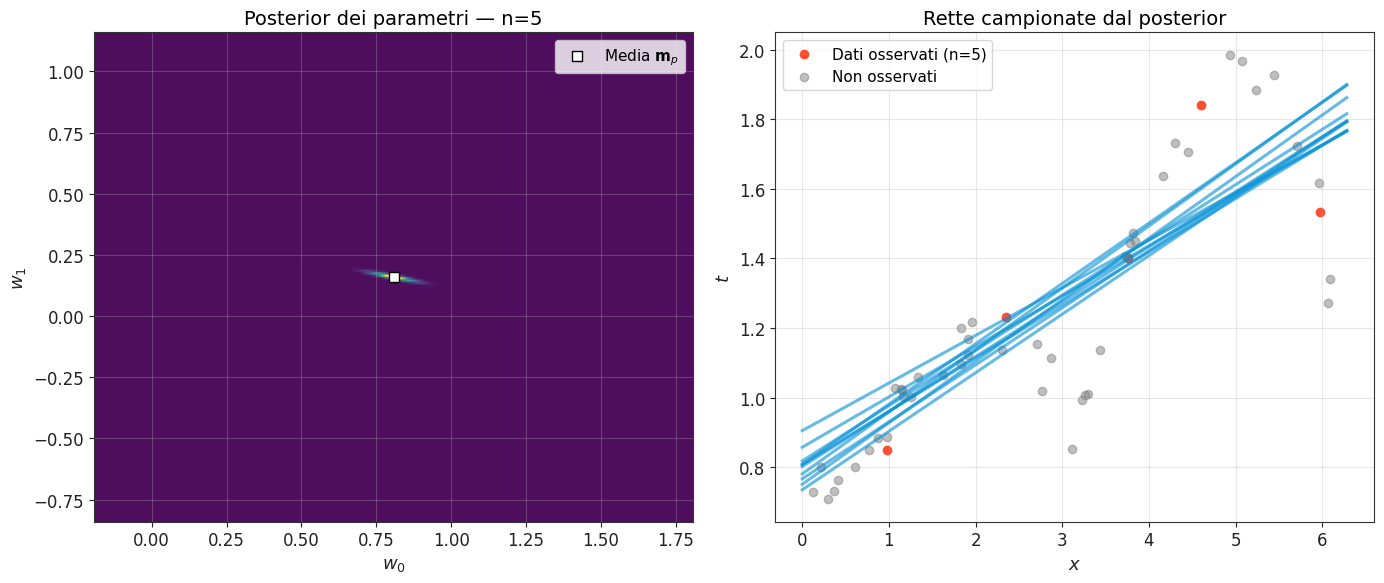

In [ ]:
# ============================================================
# 3️⃣ POSTERIOR DISTRIBUTION — BAYESIAN UPDATE
# ============================================================

def compute_posterior(Phi_t, t_t, Sigma_prior, mu_prior, beta):
    """
    Calcola la distribuzione a posteriori dei pesi:

        Σ_p = (Σ₀⁻¹ + β ΦᵀΦ)⁻¹
        μ_p = Σ_p (Σ₀⁻¹ μ₀ + β Φᵀ t)

    Parametri
    ----------
    Phi_t : ndarray (n, m)
        Matrice delle funzioni base (Φ) per gli n esempi osservati.
    t_t : ndarray (n,)
        Vettore dei target osservati.
    Sigma_prior : ndarray (m, m)
        Matrice di covarianza del prior Σ₀.
    mu_prior : ndarray (m,)
        Media del prior μ₀.
    beta : float
        Precisione del rumore (β = 1 / σ²).

    Ritorna
    -------
    mu_post : ndarray (m,)
        Media della distribuzione a posteriori.
    Sigma_post : ndarray (m, m)
        Covarianza della distribuzione a posteriori.
    """
    # Inversa della covarianza prior
    Sigma0_inv = np.linalg.inv(Sigma_prior)

    # Precisione totale: Σ₀⁻¹ + β ΦᵀΦ
    precision_post = Sigma0_inv + beta * (Phi_t.T @ Phi_t)

    # Covarianza posterior (inversa della precisione)
    Sigma_post = np.linalg.inv(precision_post)

    # Media posterior
    mu_post = Sigma_post @ (Sigma0_inv @ mu_prior.reshape(-1, 1) + beta * Phi_t.T @ t_t.reshape(-1, 1))

    # Check di simmetria numerica
    assert np.allclose(Sigma_post, Sigma_post.T, atol=1e-10), "Posterior non simmetrico!"

    return mu_post.ravel(), Sigma_post


# ============================================================
# 🔹 ESEMPIO: posterior dopo l’osservazione di n=5 dati
# ============================================================

l = 5
Phi_t, t_t = Phi[:l, :], t[:l]

mu_post, Sigma_post = compute_posterior(Phi_t, t_t, Sigma_prior, mu_prior, beta)

print("Media del posterior (μ_post):")
print(mu_post)
print("\nCovarianza del posterior (Σ_post):")
print(Sigma_post)

# ============================================================
# 🔹 Visualizzazione: posterior e rette campionate
# ============================================================

plt.figure(figsize=(14, 6))

# --- Posterior in (w0, w1) ---
posterior_pdf = st.multivariate_normal(mean=mu_post, cov=Sigma_post)
w0_grid = np.linspace(mu_post[0] - 1, mu_post[0] + 1, 200)
w1_grid = np.linspace(mu_post[1] - 1, mu_post[1] + 1, 200)
Z_post = np.array([[posterior_pdf.pdf([w0, w1]) for w0 in w0_grid] for w1 in w1_grid])

plt.subplot(1, 2, 1)
plt.imshow(Z_post, extent=(w0_grid.min(), w0_grid.max(), w1_grid.min(), w1_grid.max()),
           origin='lower', aspect='auto', alpha=0.95, cmap='viridis')
plt.scatter(mu_post[0], mu_post[1], color='white', edgecolor='black', marker='s', s=50, label="Media $\\mathbf{m}_p$")
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.title(f"Posterior dei parametri — n={l}")
plt.legend()

# --- Rette di regressione dal posterior ---
plt.subplot(1, 2, 2)
plt.scatter(X[:l], t[:l], color="#fc4f30", label=f"Dati osservati (n={l})")
plt.scatter(X[l:], t[l:], color="gray", alpha=0.5, label="Non osservati")

for w in np.random.multivariate_normal(mu_post, Sigma_post, 10):
    plt.plot(xx, Phi_xx @ w, color="#008fd5", alpha=0.6)

plt.xlabel("$x$")
plt.ylabel("$t$")
plt.title("Rette campionate dal posterior")
plt.legend()

plt.tight_layout()
plt.show()

### 🧠 Interpretazione

- **A sinistra:** la distribuzione a posteriori $p(\mathbf{w} | \mathbf{X}, \mathbf{t})$  
  risulta più concentrata rispetto al prior: l’osservazione dei dati riduce l’incertezza sui parametri del modello.

- **A destra:** le rette campionate dal posterior si addensano attorno a una direzione coerente con i dati osservati.  
  In pratica, il modello aggiorna la propria convinzione su quali valori di $\mathbf{w}$ siano plausibili.

💡 All’aumentare del numero di esempi osservati ($n$), la distribuzione a posteriori  
diventa progressivamente **più stretta** e centrata vicino ai veri parametri generativi della funzione.  
Questo riflette il comportamento tipico dell’apprendimento bayesiano:  
ogni nuovo dato **raffina** la conoscenza, riducendo l’incertezza.

## 4️⃣ Sequential Learning — Aggiornamento progressivo del posterior

Una delle caratteristiche più eleganti dell’approccio **bayesiano** è la sua **coerenza sequenziale**:  
la conoscenza appresa da un insieme di dati può essere riutilizzata come *prior* per i dati successivi.

---

### 🔁 Aggiornamento progressivo

Supponiamo di osservare un primo sottoinsieme di dati:

$$
\mathscr{T}_1 = \{(\mathbf{x}_i, t_i)\}_{i=1}^{n_1}
$$

Dopo questa osservazione, la distribuzione a posteriori dei parametri diventa:

$$
p(\mathbf{w} | \mathscr{T}_1) \propto p(\mathscr{T}_1 | \mathbf{w}) \, p(\mathbf{w})
$$

Quando arrivano nuovi dati $\mathscr{T}_2$, possiamo semplicemente aggiornare la conoscenza già acquisita:

$$
p(\mathbf{w} | \mathscr{T}_1, \mathscr{T}_2)
\propto p(\mathscr{T}_2 | \mathbf{w}) \, p(\mathbf{w} | \mathscr{T}_1)
$$

E così via, per ogni nuovo blocco di dati $\mathscr{T}_3, \ldots, \mathscr{T}_n$.

---

### 💡 Intuizione

Ad ogni passo:
> il *posterior* ottenuto diventa il nuovo *prior* per l’aggiornamento successivo.

Questo significa che il modello non “dimentica” ciò che ha imparato:  
ogni nuovo dato **raffina** la conoscenza precedente, rendendo la distribuzione sempre più concentrata  
attorno ai valori plausibili dei parametri.

---

🎯 Nel codice che segue, visualizzeremo come la distribuzione a posteriori  
si restringe progressivamente all’aumentare del numero di punti osservati.

🔁 Online Bayesian Learning — Aggiornamento con nuovi dati

📦 Step 1: aggiunti 1 nuovi dati → totale n=1
   Varianza media posterior: 1.0002


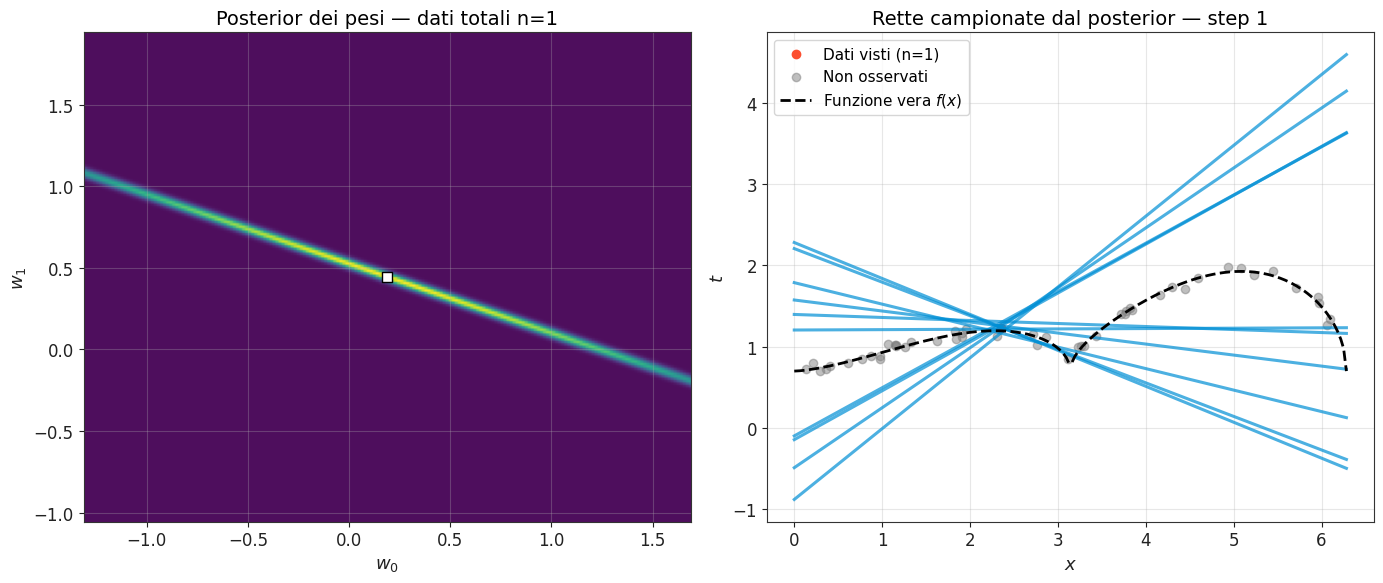

📦 Step 2: aggiunti 1 nuovi dati → totale n=2
   Varianza media posterior: 0.0041


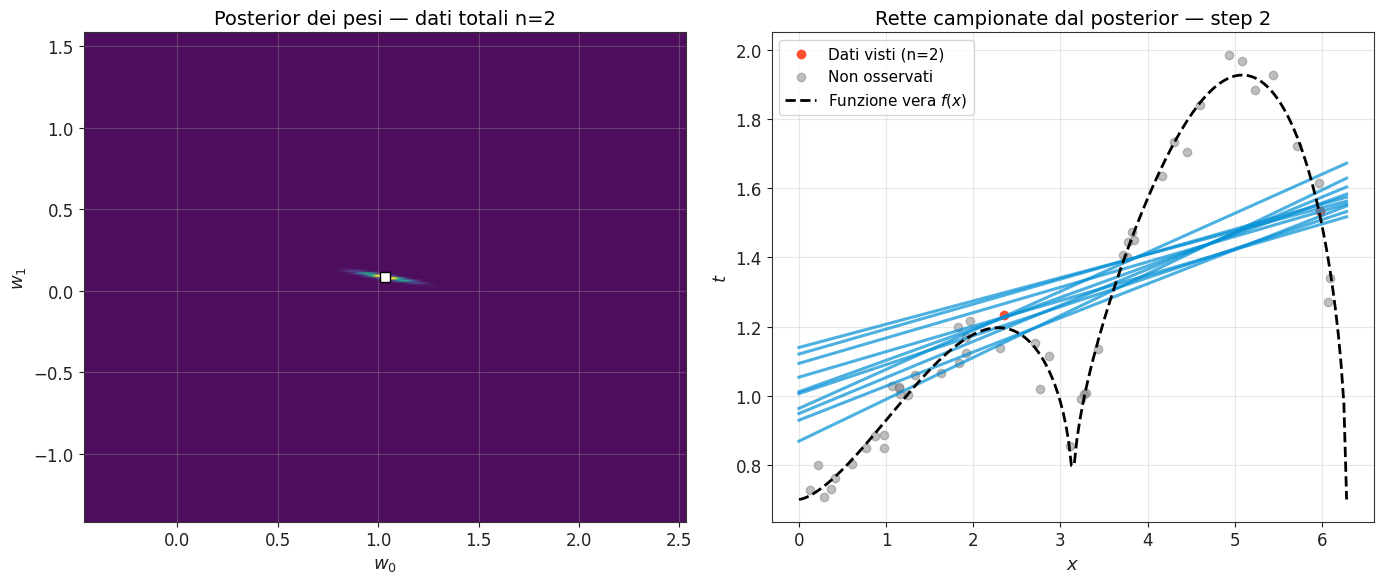

📦 Step 3: aggiunti 2 nuovi dati → totale n=4
   Varianza media posterior: 0.0036


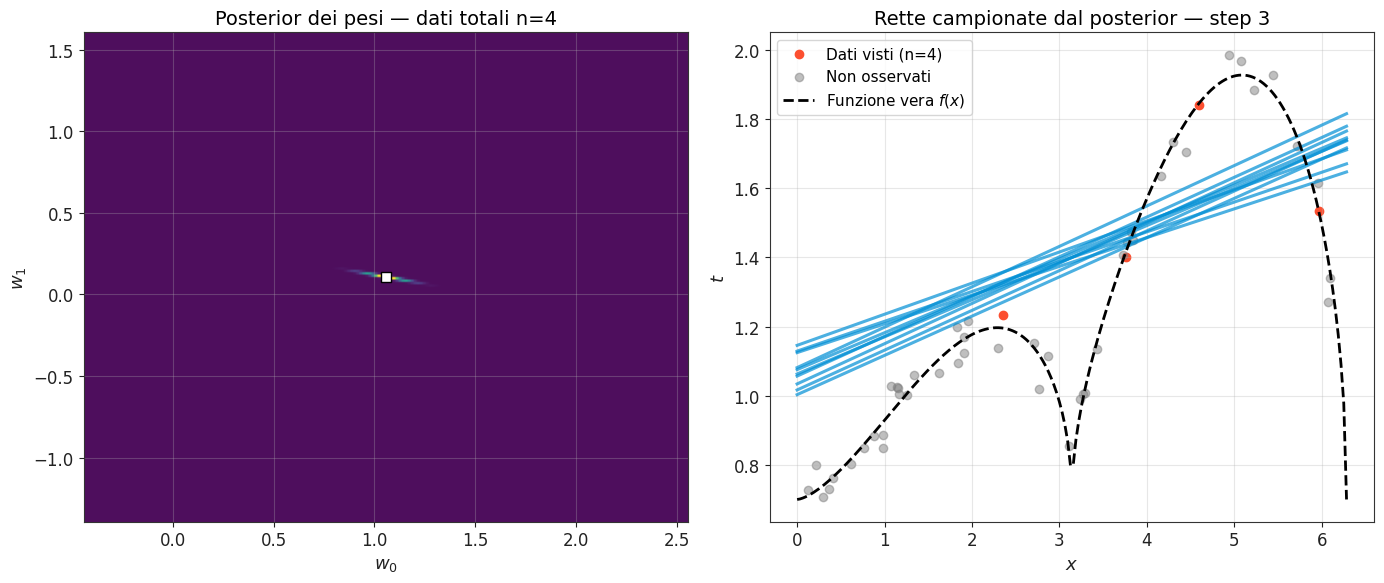

📦 Step 4: aggiunti 2 nuovi dati → totale n=6
   Varianza media posterior: 0.0009


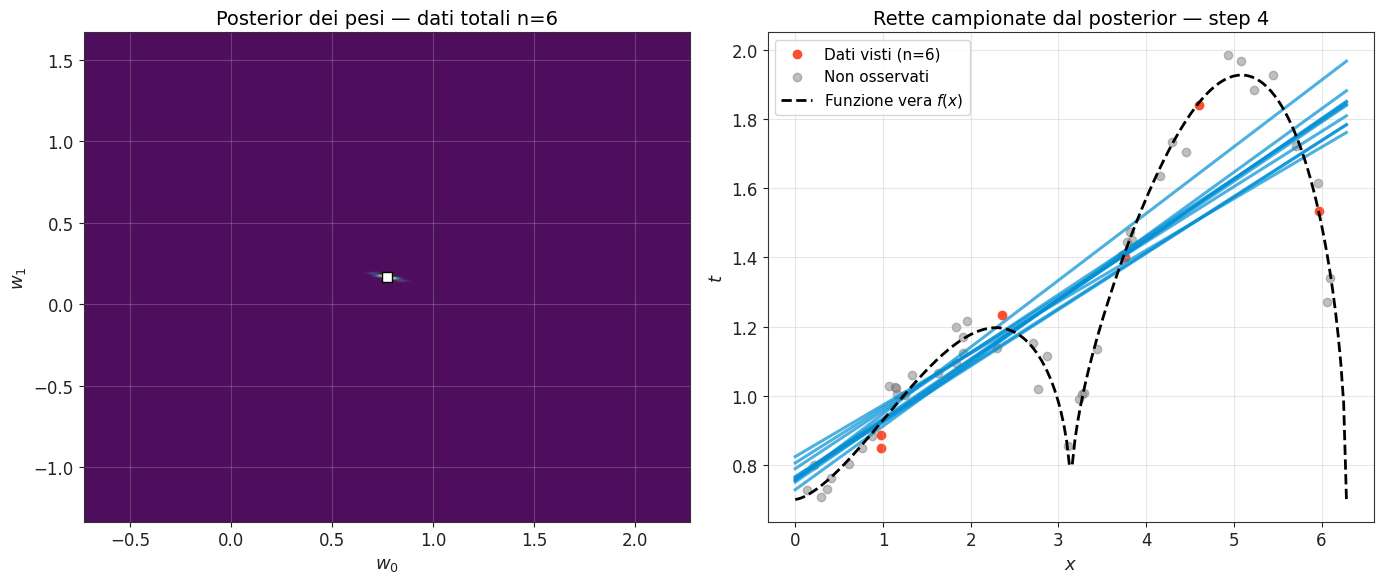

📦 Step 5: aggiunti 2 nuovi dati → totale n=8
   Varianza media posterior: 0.0005


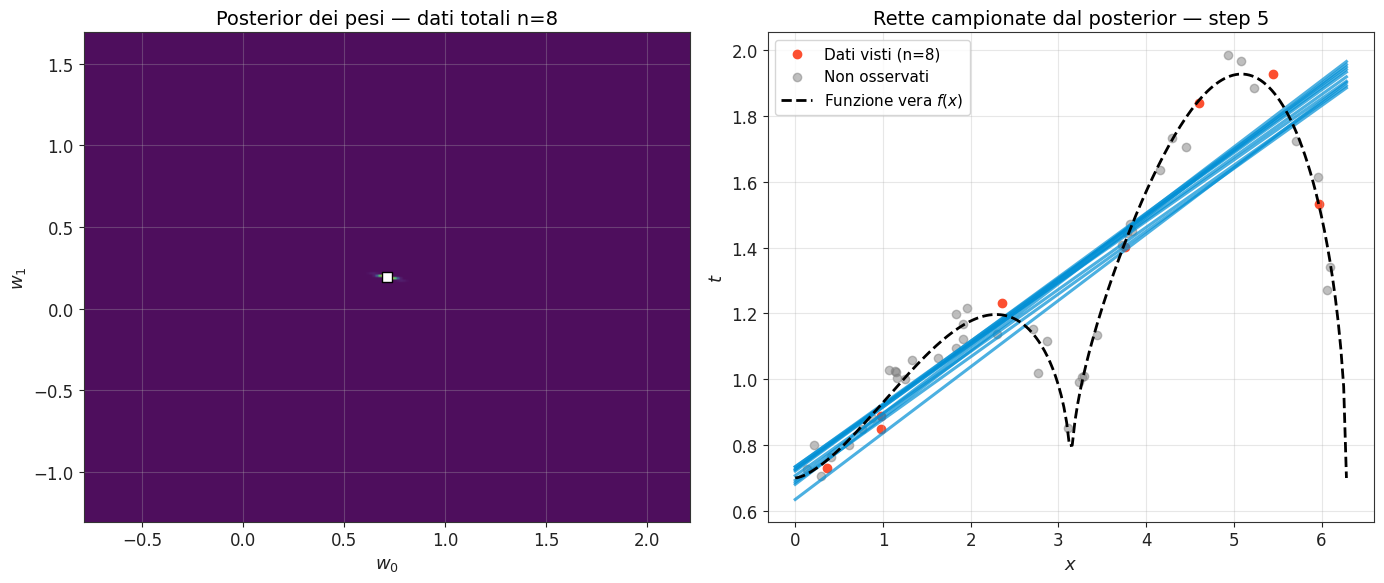

In [ ]:
# ============================================================
# 4️⃣ ONLINE BAYESIAN LEARNING — AGGIORNAMENTO PROGRESSIVO
# ============================================================

# Blocchi di dati "nuovi" osservati in sequenza
batches = [1, 1, 2, 2, 2]  # numero di nuovi esempi a ogni step

# Prior iniziale (da blocco precedente)
mu_prev = mu_prior.copy()
Sigma_prev = Sigma_prior.copy()

print("🔁 Online Bayesian Learning — Aggiornamento con nuovi dati\n")

# Funzione vera (definita in precedenza)
true_fun = f

start = 0
total_seen = 0

for i, batch_size in enumerate(batches):
    # Dati NUOVI (non riutilizziamo i vecchi)
    end = start + batch_size
    Phi_new, t_new = Phi[start:end, :], t[start:end]

    # Aggiorna posterior con i nuovi dati e il prior corrente
    mu_post, Sigma_post = compute_posterior(Phi_new, t_new, Sigma_prev, mu_prev, beta)

    # Aggiorna prior per lo step successivo
    mu_prev, Sigma_prev = mu_post, Sigma_post
    total_seen += batch_size

    # --- Metriche di incertezza e accuratezza
    var_mean = np.trace(Sigma_post) / len(Sigma_post)
    y_pred = Phi_xx @ mu_post

    # --- Output testuale
    print(f"📦 Step {i+1}: aggiunti {batch_size} nuovi dati → totale n={total_seen}")
    print(f"   Varianza media posterior: {var_mean:.4f}")

    # ------------------------------------------------------------
    # VISUALIZZAZIONE
    # ------------------------------------------------------------
    posterior_pdf = st.multivariate_normal(mean=mu_post, cov=Sigma_post)
    w0_grid = np.linspace(mu_post[0] - 1.5, mu_post[0] + 1.5, 200)
    w1_grid = np.linspace(mu_post[1] - 1.5, mu_post[1] + 1.5, 200)
    Z_post = np.array([[posterior_pdf.pdf([w0, w1]) for w0 in w0_grid] for w1 in w1_grid])

    plt.figure(figsize=(14, 6))

    # --- Distribuzione dei pesi (posterior)
    plt.subplot(1, 2, 1)
    plt.imshow(Z_post,
               extent=(w0_grid.min(), w0_grid.max(), w1_grid.min(), w1_grid.max()),
               origin='lower', aspect='auto', cmap='viridis', alpha=0.95)
    plt.scatter(mu_post[0], mu_post[1], color='white', edgecolor='black', marker='s', s=50)
    plt.title(f"Posterior dei pesi — dati totali n={total_seen}")
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")

    # --- Rette campionate dal posterior
    plt.subplot(1, 2, 2)
    plt.scatter(X[:total_seen], t[:total_seen], color="#fc4f30", label=f"Dati visti (n={total_seen})")
    plt.scatter(X[total_seen:], t[total_seen:], color="gray", alpha=0.5, label="Non osservati")

    for w in np.random.multivariate_normal(mu_post, Sigma_post, 10):
        plt.plot(xx, Phi_xx @ w, color="#008fd5", alpha=0.7)

    plt.plot(xx, true_fun(xx), 'k--', lw=2, label="Funzione vera $f(x)$")
    plt.title(f"Rette campionate dal posterior — step {i+1}")
    plt.xlabel("$x$")
    plt.ylabel("$t$")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Avanza al prossimo blocco
    start = end

### 🔍 Analisi dei risultati

- **Step 1 (n = 1)** → dopo aver visto un solo punto, il *posterior* è quasi identico al *prior*:  
  l’incertezza è altissima e le rette campionate sono estremamente variabili.

- **Step 2 (n = 2)** → con un secondo dato, il modello inizia appena a orientarsi:  
  la distribuzione dei pesi si sposta leggermente, ma resta molto ampia.

- **Step 3 (n = 4)** → con più osservazioni, il *posterior* comincia a concentrarsi:  
  il modello riconosce la direzione generale della relazione tra $x$ e $t$.

- **Step 4 (n = 6)** → la distribuzione si restringe visibilmente:  
  le rette campionate diventano più coerenti e attraversano meglio i punti osservati.

- **Step 5 (n = 8)** → il *posterior* è ormai ben concentrato attorno ai valori plausibili di $w_0$ e $w_1$:  
  il modello ha appreso la forma generale della funzione $f(x)$  
  e le predizioni diventano stabili e precise.

---

📈 Questo esperimento mostra la **natura progressiva dell’apprendimento bayesiano**: ogni nuovo dato *aggiorna* la nostra conoscenza senza dover rivedere il passato. La distribuzione dei pesi si restringe gradualmente, segno che il modello diventa sempre più **certo**  
delle relazioni che ha imparato dai dati.

## 5️⃣ Distribuzione predittiva bayesiana

Finora abbiamo stimato la **distribuzione a posteriori dei pesi** del modello:

$$
p(\mathbf{w} | \mathbf{X}, \mathbf{t}) = \mathscr{N}(\mathbf{w}; \mathbf{m}_p, \Sigma_p)
$$

Questa distribuzione ci dice **quanto siamo incerti sui parametri** del modello dopo aver visto i dati.  
Ma quello che vogliamo, in pratica, è **predire nuovi valori target** $t_*$ per un nuovo input $ \mathbf{x}_* $.

---

### 🎯 L’idea chiave

Nel mondo **bayesiano**, non scegliamo un singolo vettore di pesi $\mathbf{w}$,  
ma consideriamo **tutti i modelli possibili**, pesandoli secondo quanto sono plausibili.  

👉 La previsione finale sarà quindi una **media ponderata delle predizioni** di tutti i modelli possibili.

Formalmente, la distribuzione predittiva si ottiene integrando sullo spazio dei pesi:

$$
p(t_* | \mathbf{x}_*, \mathbf{X}, \mathbf{t})
= \int p(t_* | \mathbf{x}_*, \mathbf{w}) \, p(\mathbf{w} | \mathbf{X}, \mathbf{t}) \, d\mathbf{w}
$$

In altre parole:

- $p(t_* | \mathbf{x}_*, \mathbf{w})$ → **quanto il modello con pesi $\mathbf{w}$**  ritiene probabile il nuovo valore $t_*$

- $p(\mathbf{w} | \mathbf{X}, \mathbf{t})$ → **quanto è plausibile quel modello** dopo aver visto i dati

> Stiamo quindi integrando (“sommando”) le predizioni di tutti i modelli,  
> pesandole per quanto ogni modello è credibile secondo il *posterior*.

---

### 🧮 Forma chiusa della distribuzione

Nel caso lineare con rumore gaussiano:
- la **likelihood** $p(t_* | \mathbf{x}_*, \mathbf{w})$ è gaussiana,
- il **posterior** $p(\mathbf{w} | \mathbf{X}, \mathbf{t})$ è gaussiano.

L’integrale tra due gaussiane produce ancora una **Gaussiana**.  
Quindi anche la distribuzione predittiva è una **Gaussiana**:

$$
p(t_* | \mathbf{x}_*, \mathbf{X}, \mathbf{t})
= \mathscr{N}\!\big(t_* \mid m(\mathbf{x}_*), \, s^2(\mathbf{x}_*)\big)
$$

---

### 📊 Media e varianza predittiva

- **Media predittiva:**
  $$
  m(\mathbf{x}_*) = \mathbf{x}_*^\top \mathbf{m}_p
  $$

- **Varianza predittiva:**
  $$
  s^2(\mathbf{x}_*) = \frac{1}{\beta} + \mathbf{x}_*^\top \Sigma_p \mathbf{x}_*
  $$

---

### 📘 Interpretazione dei due termini

| Termine | Significato | Intuizione |
|----------|-------------|------------|
| $\displaystyle \frac{1}{\beta}$ | **Rumore osservativo** | incertezza intrinseca dei dati (misure rumorose) |
| $\displaystyle \mathbf{x}_*^\top \Sigma_p \mathbf{x}_*$ | **Incertezza sul modello** | quanto siamo incerti sui pesi — è maggiore lontano dai dati osservati |

---

### 💡 Cosa succede nella pratica

- Quando abbiamo **pochi dati**, $\Sigma_p$ è grande → il modello è molto incerto, quindi la banda di confidenza è ampia.

- Quando arrivano **più dati**, $\Sigma_p$ si riduce → il modello diventa più sicuro, e la banda di confidenza si restringe attorno alla media $m(\mathbf{x}_*)$.

In questo modo, il modello **aggrega informazione dai dati e riduce la propria incertezza** in modo coerente con la teoria bayesiana.

Stima empirica di β: 4.46
(Confronta con β definito nel primo blocco: 400.00)


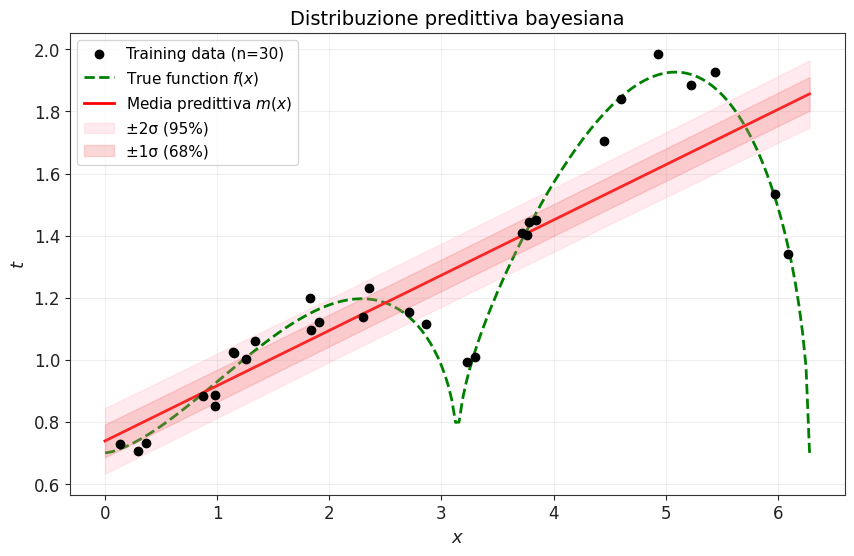

In [ ]:
# ============================================================
# 5️⃣ DISTRIBUZIONE PREDITTIVA BAYESIANA
# ============================================================

def predictive_distribution(Phi_x, mu_post, Sigma_post, beta):
    """
    Calcola media e varianza della distribuzione predittiva bayesiana.

    La distribuzione è:
        p(t_* | x_*, X, t) = 𝒩(t_* | m(x_*), s²(x_*))

    dove:
        m(x_*) = Φ(x_*) μ_post
        s²(x_*) = 1/β + Φ(x_*) Σ_post Φ(x_*)ᵀ

    Parametri:
        Phi_x      : matrice di design per i punti di test
        mu_post    : media del posterior (vettore pesi stimati)
        Sigma_post : covarianza del posterior
        beta       : precisione del rumore (β = 1/σ²)

    Ritorna:
        mean_pred : media predittiva
        var_pred  : varianza predittiva
    """
    mu_post = mu_post.reshape(-1, 1)
    mean_pred = (Phi_x @ mu_post).ravel()
    var_model = np.sum((Phi_x @ Sigma_post) * Phi_x, axis=1)  # incertezza sul modello
    var_pred = (1.0 / beta) + var_model                       # totale: rumore + modello
    return mean_pred, var_pred


# ------------------------------------------------------------
# 1️⃣ Calcolo del posterior (usiamo n = 30 dati osservati)
# ------------------------------------------------------------
l = 30
Phi_t, t_t = Phi[:l, :], t[:l]
mu_post, Sigma_post = compute_posterior(Phi_t, t_t, Sigma_prior, mu_prior, beta)

# Matrice di design per la griglia di test
Phi_test = design_matrix(xx, n_coeff)
mean_pred, var_pred = predictive_distribution(Phi_test, mu_post, Sigma_post, beta)
std_pred = np.sqrt(var_pred)

# ------------------------------------------------------------
# 2️⃣ Stima empirica del rumore dai residui
# ------------------------------------------------------------
residuals = t_t - Phi_t @ mu_post
sigma2_hat = np.mean(residuals**2)
beta_hat = 1.0 / sigma2_hat

print(f"Stima empirica di β: {beta_hat:.2f}")
print(f"(Confronta con β definito nel primo blocco: {beta:.2f})")

# Nota didattica:
# Se la stima di β differisce molto dal valore originale,
# significa che il modello non ha ancora appreso bene il livello di rumore:
# può essere dovuto a pochi dati o a una base Φ troppo rigida.
# Provare ad aumentare n_coeff o n per verificare come cambia la stima.

# ------------------------------------------------------------
# 3️⃣ Visualizzazione della distribuzione predittiva
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(X[:l], t[:l], color="black", label=f"Training data (n={l})", zorder=3)
plt.plot(xx, f(xx), "g--", linewidth=2, label="True function $f(x)$")
plt.plot(xx, mean_pred, "r", linewidth=2, label="Media predittiva $m(x)$")

# Bande di confidenza (±1σ e ±2σ)
plt.fill_between(xx, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred,
                 color="pink", alpha=0.3, label="±2σ (95%)", zorder=1)
plt.fill_between(xx, mean_pred - std_pred, mean_pred + std_pred,
                 color="lightcoral", alpha=0.3, label="±1σ (68%)", zorder=2)

plt.title("Distribuzione predittiva bayesiana")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

### 📘 Interpretazione

- La **linea rossa** mostra la **media predittiva** $m(x)$ — la miglior stima puntuale del target secondo il modello bayesiano.  

- Le **fasce colorate** rappresentano gli **intervalli di confidenza**:
  - la zona rosata chiara (±1σ) copre circa il 68% delle possibili predizioni;
  - la zona rosata più ampia (±2σ) copre circa il 95% delle possibili predizioni.

📉 Queste bande diventano più **strette** dove il modello ha visto molti dati  
e più **larghe** dove i dati sono scarsi o lontani dal dominio osservato.

---

💡 Questo è il cuore dell’approccio **bayesiano alla regressione**:  
il modello non restituisce solo una *predizione media* del valore atteso,  
ma anche una **stima esplicita dell’incertezza** associata a ogni previsione.  

In questo modo, il modello *sa quanto sa* — una caratteristica fondamentale per un apprendimento davvero probabilistico.

---

### 📈 Osservazione didattica su β

In questo esperimento, la **stima empirica di β** (precisione del rumore)  
risulta **molto più piccola** rispetto a quella definita nel dataset originale.  

Questo accade perché il modello usato (una **regressione lineare**) è troppo semplice  
per catturare la natura non lineare della funzione vera (in verde).  

➡️ Il modello quindi interpreta parte dell’errore sistematico come “rumore”,
stimando una **varianza del rumore molto più grande** (cioè β più piccolo).

---

### 🧩 Esercizio consigliato

Prova ad **aumentare il grado del polinomio** nel modello, ad esempio:
```n_coeff=5```

----

### 🧩 E dal punto di vista pratico?

Bene: ora hai le curve, le bande di confidenza e la teoria.  
Ma cosa *puoi farci* concretamente con la distribuzione predittiva?

- Puoi **stimare il valore atteso** di un nuovo punto $x_*$ → la miglior previsione del modello.  
- Puoi **quantificare l’incertezza** della previsione → dire quanto ti fidi del valore stimato.  
- Puoi **costruire intervalli di confidenza** (es. al 95%) attorno alla media.  
- Puoi **verificare la plausibilità di un nuovo dato** confrontando il suo valore osservato $t_*$ con la densità predittiva del modello.  

In sintesi:
> la distribuzione predittiva non serve solo a disegnare curve,  
> ma a **misurare la fiducia** che il modello ha nelle proprie previsioni,  
> e a capire *quanto una nuova osservazione è coerente o sorprendente*  
> rispetto a ciò che ha appreso dai dati.

In [ ]:
# ============================================================
# 🧩 Uso pratico della distribuzione predittiva
# ============================================================

from scipy.stats import norm

# Supponiamo di voler fare una previsione in un nuovo punto
x_star = 3.5           # nuovo input

# Matrice di design per il nuovo punto
Phi_star = design_matrix([x_star], n_coeff)

# Calcolo media e varianza predittiva
mean_star, var_star = predictive_distribution(Phi_star, mu_post, Sigma_post, beta)
std_star = np.sqrt(var_star)

# ------------------------------------------------------------
# 1️⃣ Stima puntuale e incertezza
# ------------------------------------------------------------
print(f"📍 Punto di test x* = {x_star:.2f}")
print(f"   Valore predetto: {mean_star[0]:.3f}")
print(f"   Incertezza (σ):  {std_star[0]:.3f}")

# ------------------------------------------------------------
# 2️⃣ Intervallo di confidenza (±2σ ≈ 95%)
# ------------------------------------------------------------
ci_low  = mean_star[0] - 2 * std_star[0]
ci_high = mean_star[0] + 2 * std_star[0]
print(f"   Intervallo di confidenza 95%: [{ci_low:.3f}, {ci_high:.3f}]")


📍 Punto di test x* = 3.50
   Valore predetto: 1.361
   Incertezza (σ):  0.051
   Intervallo di confidenza 95%: [1.259, 1.463]


---

## 🧩 Collegamento tra Ridge Regression e Regressione Bayesiana

A prima vista, la **Ridge Regression** e la **Regressione Bayesiana** sembrano due approcci diversi:
- la Ridge nasce come **ottimizzazione deterministica**, dove si minimizza una funzione di costo;
- la Bayesiana nasce come **modellazione probabilistica**, dove si aggiornano distribuzioni di probabilità.

In realtà, sono **due facce della stessa medaglia** 👇

---

### 🎯 1️⃣ Punto di partenza: il costo della Ridge

La Ridge minimizza:

$$
E_\lambda(\mathbf{w})
= \frac{1}{2n}\|\Phi\mathbf{w} - \mathbf{t}\|^2
+ \frac{\lambda}{2}\|\mathbf{w}\|^2
$$

che porta alla soluzione:

$$
\mathbf{w}^* = \bigg(\frac{1}{n}\Phi^\top \Phi + \lambda I\bigg)^{-1}\frac{1}{n}\Phi^\top \mathbf{t}
= (\Phi^\top \Phi + n\lambda I)^{-1}\Phi^\top \mathbf{t}.
$$

---

### 📊 2️⃣ Vista bayesiana

Nel formalismo bayesiano assumiamo due ipotesi gaussiane:

- **Prior sui pesi**
  $$
  p(\mathbf{w}) = \mathscr{N}(\mathbf{w}\mid 0, \alpha^{-1}I)
  $$
- **Likelihood dei dati**
  $$
  p(\mathbf{t}\mid \Phi,\mathbf{w},\beta)
  = \mathscr{N}(\mathbf{t}\mid \Phi\mathbf{w}, \beta^{-1}I)
  $$

Applicando il teorema di Bayes:

$$
p(\mathbf{w}\mid \Phi,\mathbf{t})
\propto
p(\mathbf{t}\mid \Phi,\mathbf{w})\,p(\mathbf{w})
$$

Il risultato è un **posterior gaussiano** sui pesi:

$$
p(\mathbf{w}\mid \Phi,\mathbf{t})
= \mathscr{N}(\mathbf{w}\mid \mathbf{m}_p,\Sigma_p)
$$

dove:

$$
\Sigma_p^{-1} = \alpha I + \beta \Phi^\top\Phi,
\qquad
\mathbf{m}_p = \beta\,\Sigma_p\,\Phi^\top\mathbf{t}.
$$

---

### 🔗 3️⃣ Identificazione con la Ridge

Partiamo dal risultato bayesiano:

$$
\Sigma_p^{-1} = \alpha I + \beta \Phi^\top\Phi,
\qquad
\mathbf{m}_p = \beta\,\Sigma_p\,\Phi^\top\mathbf{t}.
$$

Sostituiamo la prima nella seconda:

$$
\mathbf{m}_p
= \beta(\alpha I + \beta \Phi^\top\Phi)^{-1}\Phi^\top\mathbf{t}.
$$

Ora, per confrontarla con la **soluzione Ridge**, portiamo fuori il fattore $\beta$ dal denominatore:

$$
\mathbf{m}_p
= (\Phi^\top\Phi + \tfrac{\alpha}{\beta}I)^{-1}\Phi^\top\mathbf{t}.
$$

---

Confrontando con la formula della Ridge Regression:

$$
\mathbf{w}^*_{\text{ridge}}
= (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top \mathbf{t},
$$

vediamo che le due espressioni **sono identiche** se poniamo:

$$
\boxed{\lambda = \frac{\alpha}{\beta}}
$$

---

👉 Quindi:

- La **media del posterior bayesiano** $\mathbf{m}_p$ coincide esattamente con la **soluzione Ridge** $\mathbf{w}^*_{\text{ridge}}$.  
- La **covarianza del posterior** $\Sigma_p$ fornisce in più la **misura dell’incertezza sui pesi**,  
  informazione che la Ridge standard non include.

In sintesi:
> - Ridge = massimo a posteriori (MAP) del modello bayesiano.  
> - Bayesian Regression = stessa media + distribuzione completa.

---

### 📘 In sintesi

- **Ridge Regression** → trova il *punto di massimo a posteriori (MAP)* del modello bayesiano.  
- **Regressione Bayesiana** → stima l’intera **distribuzione** dei pesi,  
  includendo la misura dell’**incertezza residua**.

💡 In altre parole:  
> La Ridge è la versione “senza incertezza” della Regressione Bayesiana.  
> La Bayesiana fa tutto ciò che fa la Ridge — ma **in modo probabilisticamente coerente**.

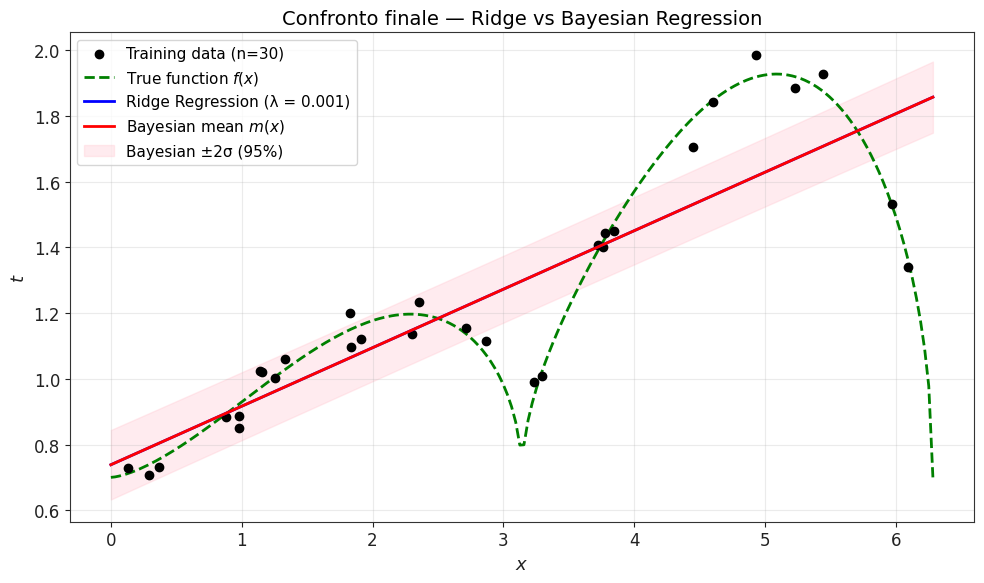

In [ ]:
# ============================================================
# 🎯 6️⃣ CONFRONTO FINALE — RIDGE vs BAYESIAN REGRESSION
# ============================================================

from sklearn.linear_model import Ridge

# ------------------------------------------------------------
# 1️⃣ Mapping teorico tra Bayes e Ridge
# ------------------------------------------------------------
# λ = α / β  → regolarizzazione equivalente
lam = alpha / beta

# Addestramento del modello Ridge (stessa base Φ)
ridge = Ridge(alpha=lam, fit_intercept=False)
ridge.fit(Phi_t, t_t.ravel())

# Predizioni Ridge sulla griglia di test
y_ridge = ridge.predict(Phi_test)

# ------------------------------------------------------------
# 2️⃣ Visualizzazione del confronto
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Dati osservati
plt.scatter(X[:l], t[:l], color="black", label=f"Training data (n={l})", zorder=3)

# Funzione vera
plt.plot(xx, f(xx), "g--", linewidth=2, label="True function $f(x)$", zorder=2)

# Soluzione Ridge
plt.plot(xx, y_ridge, "b", linewidth=2, label=f"Ridge Regression (λ = {lam:.3f})", zorder=3)

# Media predittiva Bayesiana
plt.plot(xx, mean_pred, "r", linewidth=2, label="Bayesian mean $m(x)$", zorder=4)

# Intervallo di confidenza (±2σ)
plt.fill_between(xx,
                 mean_pred - 2 * std_pred,
                 mean_pred + 2 * std_pred,
                 color="pink", alpha=0.3,
                 label="Bayesian ±2σ (95%)", zorder=1)

# ------------------------------------------------------------
# Dettagli grafici
# ------------------------------------------------------------
plt.title("Confronto finale — Ridge vs Bayesian Regression")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## 🎯 6️Confronto finale — Ridge vs Bayesian Regression

A questo punto possiamo confrontare direttamente la **Ridge Regression** e la **Regressione Bayesiana**.

Per garantire un confronto corretto, ricordiamo la relazione teorica tra i parametri:
$$
\lambda = \frac{\alpha}{\beta}.
$$

Utilizziamo quindi lo stesso valore di regolarizzazione per la Ridge e per il prior bayesiano.

---

### 📊 Cosa vediamo nel grafico

- **Linea blu** → soluzione della **Ridge Regression**:  
  corrisponde al *punto di massimo a posteriori (MAP)* del modello bayesiano.  
  È una singola stima deterministica dei pesi. PS: *non la vedi perchè è sovrapposta alla linea rossa!!!*

- **Linea rossa** → **media predittiva bayesiana** $m(x)$:  
  coincide esattamente con la soluzione Ridge, come previsto dalla teoria.

- **Fascia rosa** → **intervallo di confidenza bayesiano** (±2σ):  
  mostra l’incertezza del modello, più ampia dove i dati sono scarsi  
  e più stretta dove il modello ha più evidenza.

- **Linea verde tratteggiata** → la **vera funzione generatrice** $f(x)$.

---

### 💡 Interpretazione

| Modello | Output | Tipo di soluzione |
|----------|---------|------------------|
| **Ridge Regression** | $$\mathbf{w}^*_{\text{ridge}} = (\Phi^\top\Phi + \lambda I)^{-1}\Phi^\top\mathbf{t}$$ | Singolo punto (stima deterministica) |
| **Bayesian Regression** | $$p(\mathbf{w}|\Phi,\mathbf{t}) = \mathscr{N}(\mathbf{m}_p, \Sigma_p)$$ | Distribuzione (stima probabilistica) |

📘 In altre parole:
> - La **Ridge** fornisce *solo* la media del posterior (una soluzione).  
> - La **Bayesiana** fornisce *la distribuzione intera*, quindi anche l’incertezza.

---

✅ **Conclusione**
- La Ridge Regression è un caso particolare della Regressione Bayesiana.  
- Entrambe producono la stessa media, ma la Bayesiana aggiunge informazione preziosa:  
  la **stima dell’incertezza** sulle predizioni e sui parametri.